In [1]:
#compact convolutional transformer
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sklearn.metrics as skl
from sklearn.model_selection import train_test_split

In [2]:
#pickle
with open('mass_imgs.pkl', 'rb') as f:
    imgs = pickle.load(f)
with open('mass_labels.pkl', 'rb') as f:
    labels = pickle.load(f)

In [3]:
#split images
train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.1, shuffle=True)
rescale = tf.keras.Sequential([
        tf.keras.layers.Rescaling(scale=1 / 255)
    ])
with tf.device('/cpu:0'):
    train_imgs = rescale(train_imgs)
    test_imgs = rescale(test_imgs)

In [4]:
#augmentation
augmenter_func = tf.keras.Sequential(
  layers=[
        tf.keras.layers.RandomFlip(),
        tf.keras.layers.RandomRotation(0.25),
        tf.keras.layers.RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2)),
        tf.keras.layers.RandomTranslation(height_factor=(-0.15,0.15), width_factor=(-0.15,0.15)),
    ]
)

def orthogonal_rot(image):
    return np.rot90(image, np.random.choice([-1, 0, 1]))

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=orthogonal_rot
)

In [5]:
#plotting data
# augmented_1 = augmenter_func(train_imgs[:25])
# augmented_2 = augmenter_func(train_imgs[:25])

# plt.figure(figsize=(10, 10))
# for n in range(25):
#     ax = plt.subplot(5, 5, n + 1)
#     plt.imshow(augmented_1[n].numpy().astype("int"))
#     plt.axis("off")
# plt.show()

# plt.figure(figsize=(10, 10))
# for n in range(25):
#     ax = plt.subplot(5, 5, n + 1)
#     plt.imshow(augmented_2[n].numpy().astype("int"))
#     plt.axis("off")
# plt.show()

In [6]:
#hyperparams
positional_emb = True
conv_layers = 3
projection_dim = 128

num_heads = 2
transformer_units = [
    projection_dim,
    projection_dim,
]
transformer_layers = 2
stochastic_depth_rate = 0.1

learning_rate = 0.0001
weight_decay = 0.0001
batch_size = 256
num_epochs = 10
image_size = 150

PROJECT_DIM = 2048
LATENT_DIM = 512

In [9]:
#tokenizer class
class CCTTokenizer(tf.keras.layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        num_output_channels=[32, 64, 128],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.conv_model = tf.keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                tf.keras.layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(tf.keras.layers.ZeroPadding2D(padding))
            self.conv_model.add(
                tf.keras.layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        reshaped = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]),
        )
        return reshaped

    def positional_embedding(self, image_size):
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, image_size, 1))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = tf.shape(dummy_outputs)[1]
            projection_dim = tf.shape(dummy_outputs)[-1]

            embed_layer = tf.keras.layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length
        else:
            return None

In [8]:
#stochasticdepth
class StochasticDepth(tf.keras.layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (tf.shape(x).shape[0] - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

In [10]:
#mlp
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = tf.keras.layers.Dense(units, activation=tf.nn.gelu)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

In [11]:
#CCT backbone
# def create_cct_model():

#     inputs = tf.keras.layers.Input((150,150,1))

#     # Encode patches.
#     cct_tokenizer = CCTTokenizer()
#     encoded_patches = cct_tokenizer(inputs)

#     # Apply positional embedding.
#     if positional_emb:
#         pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
#         positions = tf.range(start=0, limit=seq_length, delta=1)
#         position_embeddings = pos_embed(positions)
#         encoded_patches += position_embeddings

#     # Calculate Stochastic Depth probabilities.
#     dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

#     # Create multiple layers of the Transformer block.
#     for i in range(transformer_layers):
#         # Layer normalization 1.
#         x1 = tf.keras.layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

#         # Create a multi-head attention layer.
#         attention_output = tf.keras.layers.MultiHeadAttention(
#             num_heads=num_heads, key_dim=projection_dim, dropout=0.1
#         )(x1, x1)

#         # Skip connection 1.
#         attention_output = StochasticDepth(dpr[i])(attention_output)
#         x2 = tf.keras.layers.Add()([attention_output, encoded_patches])

#         # Layer normalization 2.
#         x3 = tf.keras.layers.LayerNormalization(epsilon=1e-5)(x2)

#         # MLP.
#         x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

#         # Skip connection 2.
#         x3 = StochasticDepth(dpr[i])(x3)
#         encoded_patches = tf.keras.layers.Add()([x3, x2])

#     # Apply sequence pooling.
#     representation = tf.keras.layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
#     attention_weights = tf.nn.softmax(tf.keras.layers.Dense(1)(representation), axis=1)
#     weighted_representation = tf.matmul(
#         attention_weights, representation, transpose_a=True
#     )
#     weighted_representation = tf.squeeze(weighted_representation, -2)

#     # Create the Keras model.
#     model = tf.keras.Model(inputs=inputs, outputs=weighted_representation, name='CCT')
#     return model

In [12]:
#encoder and decoder for simsiam architecture,
#compact convolutional transfromer is included in the encoder
def get_encoder():

    inputs = tf.keras.layers.Input((150,150,1))

    # Encode patches.
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(inputs)

    # Apply positional embedding.
    if positional_emb:
        pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)
        position_embeddings = pos_embed(positions)
        encoded_patches += position_embeddings

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = tf.keras.layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-5)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = tf.keras.layers.Add()([x3, x2])

    # Apply sequence pooling.
    representation = tf.keras.layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    attention_weights = tf.nn.softmax(tf.keras.layers.Dense(1)(representation), axis=1)
    weighted_representation = tf.matmul(
        attention_weights, representation, transpose_a=True
    )
    weighted_representation = tf.squeeze(weighted_representation, -2, name="backbone_rep")

    # Projection head.
    x = tf.keras.layers.Dense(
        PROJECT_DIM, use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(weight_decay)
    )(weighted_representation)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dense(
        PROJECT_DIM, use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(weight_decay)
    )(x)
    outputs = tf.keras.layers.BatchNormalization()(x)
    
    return tf.keras.Model(inputs, outputs, name="encoder")

def get_predictor():
    model = tf.keras.Sequential(
        [
            # Note the AutoEncoder-like structure.
            tf.keras.layers.Input((PROJECT_DIM,)),
            tf.keras.layers.Dense(
                LATENT_DIM,
                use_bias=False,
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
            ),
            tf.keras.layers.ReLU(),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(PROJECT_DIM),
        ],
        name="predictor",
    )
    return model

In [13]:
#loss function
def compute_loss(p, z):
    z = tf.stop_gradient(z)
    p = tf.math.l2_normalize(p, axis=1)
    z = tf.math.l2_normalize(z, axis=1)
    return -tf.reduce_mean(tf.reduce_sum((p * z), axis=1))  

In [14]:
#simsiam model 
class SimSiam(tf.keras.Model):
    def __init__(self, encoder, predictor, augmenter):
        super().__init__()
        self.encoder = encoder
        self.predictor = predictor
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.augmenter = augmenter

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        ds_one, ds_two = self.augmenter(data), self.augmenter(data)

        with tf.GradientTape() as tape:
            z1, z2 = self.encoder(ds_one), self.encoder(ds_two)
            p1, p2 = self.predictor(z1), self.predictor(z2)
            loss = compute_loss(p1, z2) / 2 + compute_loss(p2, z1) / 2

        learnable_params = (
            self.encoder.trainable_variables + self.predictor.trainable_variables
        )
        gradients = tape.gradient(loss, learnable_params)
        self.optimizer.apply_gradients(zip(gradients, learnable_params))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

Epoch 1/14
282/282 [==============================] - 88s 287ms/step - loss: -0.1722
Epoch 2/14
282/282 [==============================] - 82s 291ms/step - loss: -0.3029
Epoch 3/14
282/282 [==============================] - 84s 300ms/step - loss: -0.3755
Epoch 4/14
282/282 [==============================] - 87s 308ms/step - loss: -0.4301
Epoch 5/14
282/282 [==============================] - 88s 311ms/step - loss: -0.4764
Epoch 6/14
282/282 [==============================] - 88s 312ms/step - loss: -0.5190
Epoch 7/14
282/282 [==============================] - 89s 317ms/step - loss: -0.5596
Epoch 8/14
282/282 [==============================] - 89s 317ms/step - loss: -0.5986
Epoch 9/14
282/282 [==============================] - 89s 316ms/step - loss: -0.6364
Epoch 10/14
282/282 [==============================] - 90s 319ms/step - loss: -0.6734
Epoch 11/14
282/282 [==============================] - 87s 308ms/step - loss: -0.7147
Epoch 12/14
282/282 [==============================] - 85s 303m

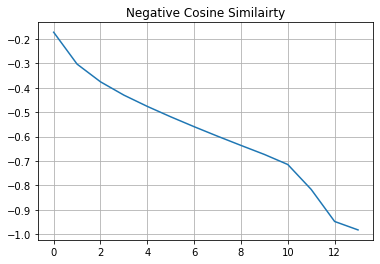

In [15]:
#train model
simsiam = SimSiam(get_encoder(), get_predictor(), augmenter_func)
simsiam.compile(optimizer=tf.keras.optimizers.SGD(0.0001, momentum=0.6))
history = simsiam.fit(train_imgs, epochs=14, batch_size=64)

plt.plot(history.history["loss"])
plt.grid()
plt.title("Negative Cosine Similairty")
plt.show()

In [16]:
#save the self supervised model
backbone = tf.keras.Model(
    simsiam.encoder.input, simsiam.encoder.get_layer('tf.compat.v1.squeeze').output
)
backbone.save('SS_CCT')

INFO:tensorflow:Assets written to: SS_CCT_5\assets


INFO:tensorflow:Assets written to: SS_CCT_5\assets


In [19]:
#fine tuning the regression model
backbone.trainable = False
inputs = tf.keras.layers.Input((150,150,1))
x = backbone(inputs, training=False)
outputs = tf.keras.layers.Dense(1)(x)
linear_model = tf.keras.Model(inputs, outputs, name="linear_model")

linear_model.compile(
    loss="mean_squared_error",
    metrics=["mean_squared_error"],
    optimizer=tf.keras.optimizers.SGD(0.0001, momentum=0.9),
)
history = linear_model.fit(
    datagen.flow(train_imgs, train_labels, batch_size=256), epochs=10
)
linear_model.save('FT_CCT')

Epoch 1/10
71/71 [==============================] - 16s 190ms/step - loss: 0.0823 - mean_squared_error: 0.0823
Epoch 2/10
71/71 [==============================] - 13s 189ms/step - loss: 8.3358e-04 - mean_squared_error: 8.3358e-04
Epoch 3/10
71/71 [==============================] - 13s 188ms/step - loss: 7.8860e-04 - mean_squared_error: 7.8860e-04
Epoch 4/10
71/71 [==============================] - 13s 189ms/step - loss: 7.9281e-04 - mean_squared_error: 7.9281e-04
Epoch 5/10
71/71 [==============================] - 14s 190ms/step - loss: 7.8984e-04 - mean_squared_error: 7.8984e-04
Epoch 6/10
71/71 [==============================] - 14s 190ms/step - loss: 7.9082e-04 - mean_squared_error: 7.9082e-04
Epoch 7/10
71/71 [==============================] - 14s 190ms/step - loss: 7.8614e-04 - mean_squared_error: 7.8614e-04
Epoch 8/10
71/71 [==============================] - 14s 196ms/step - loss: 7.8592e-04 - mean_squared_error: 7.8592e-04
Epoch 9/10
71/71 [==============================] - 14s 

INFO:tensorflow:Assets written to: FT_CCT_5\assets


INFO:tensorflow:Assets written to: FT_CCT_5\assets


In [20]:
#evaluate regression
eval = linear_model.evaluate(test_imgs, np.array(test_labels))

63/63 [==============================] - 3s 34ms/step - loss: 7.9910e-04 - mean_squared_error: 7.9910e-04
